# Finance Dashboard 

## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import streamlit as st

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [3]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

In [4]:
import json
import pickle

In [5]:
from tqdm import tqdm

## 1. Import data

- Import price-volume data from KRX using custom lib `korquanttools.pricevolume`

In [6]:
# Global parameters

START = 20140101
# START = 20210101
END = 20220520

In [7]:
pricevolume = KRXPriceDM(START, END)

In [8]:
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


In [9]:
# Download price-volume data from KRX.
# Also, build cache for faster access. (Both lv1 and lv2)

close_df = pricevolume.get_data("close")

In [10]:
close_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,37550L,388050,389140,405640,412930,413600,415580,419270,389260,399720
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,4440,438,111500,15500,73500,32600,21750,16850,182500,93300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,4540,440,114000,15400,71800,33400,21450,16850,180500,93000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,11850,791,15550,37350,81700,62900,35850,21000,57800,56800,...,40200,17250,25200,2185,2195,2460,2160,2205,13950,NaN
2022-05-17,11900,788,15450,38250,81800,62900,36950,21200,57800,56700,...,40200,17450,25400,2185,2205,2535,2155,2215,14350,NaN
2022-05-18,12000,783,15200,39750,81200,63000,36800,21150,58600,57100,...,39650,17650,25450,2190,2200,2540,2160,2210,13700,NaN


In [11]:
close_df.loc[:, '005930'] # 삼성전자. 
# 분할했었기 때문에 가격이 100만원 대에서 6만원 대로 변한다. 

trdDd
2014-01-01        NaN
2014-01-02    1309000
2014-01-03    1296000
2014-01-04        NaN
2014-01-05        NaN
               ...   
2022-05-16      66300
2022-05-17      67600
2022-05-18      68100
2022-05-19      67500
2022-05-20      68000
Name: 005930, Length: 3062, dtype: object

In [12]:
volume_df = pricevolume.get_data('volume')
dollarvolume_df = pricevolume.get_data('dollarvolume')
marketcap_df = pricevolume.get_data('marketcap') # TODO: 현재 object로 불러와져 직접 astype(float) 해줘야 함. fix it. 

In [13]:
volume_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,37550L,388050,389140,405640,412930,413600,415580,419270,389260,399720
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,99452,68243,335,115508,12328,63,276618,2400,21453,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,107190,65432,853,128224,12650,60,253501,255,21211,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,76716,132729,62916,237055,9259,85,269050,1011,118147,255,...,2428,69811,338419,36188,46794,107402,68433,25522,4096958,NaN
2022-05-17,69867,143751,4967,263953,9363,122,336620,1305,120933,289,...,2929,78778,133388,5079,33892,115312,12787,14057,1304034,NaN
2022-05-18,207503,109346,28341,305594,11524,40,266185,998,170379,554,...,8399,119741,180316,11873,34581,101786,18582,9863,958821,NaN


In [14]:
volume_df.loc[:, '005930'] # 삼성전자
# volume 역시 unadjusted volume이다. 

trdDd
2014-01-01         NaN
2014-01-02      620500
2014-01-03      529932
2014-01-04         NaN
2014-01-05         NaN
                ...   
2022-05-16    11937555
2022-05-17    15680447
2022-05-18    16486319
2022-05-19    17073727
2022-05-20    12109671
Name: 005930, Length: 3062, dtype: object

## 2. Create additional DMs


- KOSPI, KOSDAQ

In [15]:
lv1_df = pricevolume.get_data('lv1')

In [16]:
market_cat_df = lv1_df[['ISU_SRT_CD', 'MKT_NM', 'trdDd']].copy()

In [17]:
market_cat_df['MKT_NM'].unique()

array(['KOSDAQ', 'KOSPI', 'KONEX'], dtype=object)

In [18]:
market_cat_df.loc[:, 'is_KOSPI'] = (market_cat_df['MKT_NM'] == 'KOSPI')
market_cat_df.loc[:, 'is_KOSDAQ'] = (market_cat_df['MKT_NM'] == 'KOSDAQ')
market_cat_df.loc[:, 'is_KONEX'] = (market_cat_df['MKT_NM'] == 'KONEX')

In [19]:
kospi_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSPI')
kosdaq_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSDAQ')
konex_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KONEX')

In [20]:
kosdaq_univ_df.loc[:, '221610'] # 자안바이오 상폐일: 2022-01-05	

trdDd
2014-01-02    NaN
2014-01-03    NaN
2014-01-04    NaN
2014-01-05    NaN
2014-01-06    NaN
             ... 
2022-05-15    NaN
2022-05-16    NaN
2022-05-17    NaN
2022-05-18    NaN
2022-05-19    NaN
Name: 221610, Length: 3060, dtype: object


- tradingday DM by processing `pricevolume`


In [21]:
holidays = close_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

tradingdays

DatetimeIndex(['2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-14', '2014-01-15',
               ...
               '2022-05-09', '2022-05-10', '2022-05-11', '2022-05-12',
               '2022-05-13', '2022-05-16', '2022-05-17', '2022-05-18',
               '2022-05-19', '2022-05-20'],
              dtype='datetime64[ns]', name='trdDd', length=2062, freq=None)


- return & adj.open/high/low/close/volume DM by mixing `pricevolume` and `FinanceDataReader`


In [22]:
universe_df = close_df.notnull()
universe_df

ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,37550L,388050,389140,405640,412930,413600,415580,419270,389260,399720
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2014-01-02,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2014-01-03,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2014-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2014-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
2022-05-17,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
2022-05-18,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False


In [23]:
# # Takes about 20 mins

# adjOpen_df = close_df.copy()
# adjHigh_df = close_df.copy()
# adjLow_df = close_df.copy()
# adjClose_df = close_df.copy()
# adjVolume_df = close_df.copy()
# return_df = close_df.copy()

# for ii in tqdm(close_df.columns):
#     ii_df = fdr.DataReader(ii, DateUtil.numdate2stddate(START), DateUtil.numdate2stddate(END))

#     adjOpen_df.loc[:, ii] = ii_df['Open']
#     adjHigh_df.loc[:, ii] = ii_df['High']
#     adjLow_df.loc[:, ii] = ii_df['Low']
#     adjClose_df.loc[:, ii] = ii_df['Close']
#     adjVolume_df.loc[:, ii] = ii_df['Volume']
#     return_df.loc[:, ii] = ii_df['Change']
    

In [24]:
# adjOpen_df.to_pickle(PathConfig.cache_path / f"temp_adjOpen_{START}_{END}")
# adjHigh_df.to_pickle(PathConfig.cache_path / f"temp_adjHigh_{START}_{END}")
# adjLow_df.to_pickle(PathConfig.cache_path / f"temp_adjLow_{START}_{END}")
# adjClose_df.to_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
# adjVolume_df.to_pickle(PathConfig.cache_path / f"temp_adjVolume_{START}_{END}")
# return_df.to_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

In [25]:
PathConfig.cache_path

WindowsPath('C:/Users/chlje/VSCodeProjects/korquanttools/korquanttools/pricevolume/cache')

In [26]:
adjOpen_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjOpen_{START}_{END}")
adjHigh_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjHigh_{START}_{END}")
adjLow_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjLow_{START}_{END}")
adjClose_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
adjVolume_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjVolume_{START}_{END}")
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")


### (Skip for now) Download additional data for new DMs 

- KRX sector DM downloaded from KRX
    - NOT PIT(Point-In-Time)
- Corporate finance fundamental analysis data from DART (using 3rd party libraries)
    - Later on, when I need it

In [28]:
kospi_index_df = fdr.DataReader('KS11', DateUtil.numdate2stddate(START), DateUtil.numdate2stddate(END))

In [29]:
kospi_index_df

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2014-01-02,1967.19,2013.11,2013.89,1967.19,207770000.0,-0.0220
2014-01-03,1946.14,1963.72,1964.63,1936.15,188530000.0,-0.0107
2014-01-06,1953.28,1947.62,1961.85,1943.74,193630000.0,0.0037
2014-01-07,1959.44,1947.65,1965.74,1947.08,193030000.0,0.0032
2014-01-08,1958.96,1965.50,1966.95,1950.02,217070000.0,-0.0002
...,...,...,...,...,...,...
2022-05-16,2596.58,2624.69,2629.20,2593.61,780200000.0,-0.0029
2022-05-17,2620.44,2603.58,2621.84,2603.58,873520000.0,0.0092
2022-05-18,2625.98,2634.75,2644.13,2618.00,870270000.0,0.0021


## 3. Make price-volume chart graph

- Simple price-volume chart using both `seaborn`/`streamlit`
- Show biggest winners/losers on mouse hover
    - Make pseudo-KOSPI portfolio mimicking KOSPI index
    - Show Top 3 winners/losers on the graph 

### Make KOSPI index from scratch

In [30]:
kospi_firstday_value = kospi_index_df['Close'].iloc[0]
kospi_firstday_value

1967.19

<AxesSubplot:xlabel='Date'>

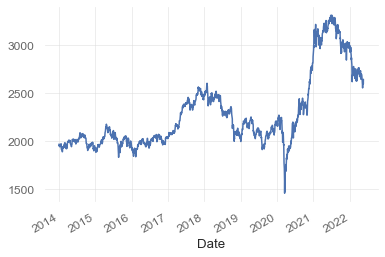

In [31]:
kospi_index_df['Close'].plot() # 목표 plot. 개별 종목 시총 데이터로 이렇게 만들어야 한다. 

In [32]:
kospi_adjClose_df = adjClose_df[kospi_univ_df]
kospi_marketcap_df = marketcap_df[kospi_univ_df]

In [33]:
kospi_adjClose_df = kospi_adjClose_df.loc[tradingdays, :]
kospi_marketcap_df = kospi_marketcap_df.loc[tradingdays, :]

In [34]:
kospi_marketcap_df = kospi_marketcap_df.astype(float)

In [35]:
kospi_marketcap_df


ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,37550L,388050,389140,405640,412930,413600,415580,419270,389260,399720
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,1.240157e+11,5.227152e+10,2.778912e+11,1.570596e+12,6.005292e+11,9.912291e+09,1.525406e+12,1.904283e+10,2.035340e+12,2.203634e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1.268089e+11,5.251021e+10,2.841220e+11,1.560464e+12,5.866394e+11,1.015554e+10,1.504366e+12,1.904283e+10,2.013035e+12,2.196548e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,1.272278e+11,5.251021e+10,2.903527e+11,1.555397e+12,5.939928e+11,1.015554e+10,1.521899e+12,1.853426e+10,2.096679e+12,2.201272e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,1.279261e+11,5.239087e+10,2.903527e+11,1.560464e+12,6.037974e+11,1.010993e+10,1.521899e+12,1.870378e+10,2.197052e+12,2.236700e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,1.321159e+11,5.298757e+10,2.841220e+11,1.560464e+12,6.013462e+11,9.881885e+09,1.511379e+12,1.853426e+10,2.230509e+12,2.231977e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,3.309879e+11,7.604487e+10,4.263074e+11,4.505344e+12,6.997009e+11,1.912525e+10,2.514290e+12,2.373290e+10,4.232779e+12,6.707739e+10,...,8.490043e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-17,3.323845e+11,7.575645e+10,4.235659e+11,4.613906e+12,7.005574e+11,1.912525e+10,2.591437e+12,2.395893e+10,4.232779e+12,6.695930e+10,...,8.490043e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-18,3.351776e+11,7.527577e+10,4.167121e+11,4.794844e+12,6.954188e+11,1.915565e+10,2.580917e+12,2.390242e+10,4.291364e+12,6.743167e+10,...,8.373886e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
kospi_calculated = kospi_marketcap_df.sum(axis=1)
normalize_coef = kospi_firstday_value / kospi_calculated.iloc[0]
kospi_calculated = kospi_calculated * normalize_coef
kospi_calculated

trdDd
2014-01-02    1967.190000
2014-01-03    1945.638220
2014-01-06    1953.500875
2014-01-07    1959.143372
2014-01-08    1959.462409
                 ...     
2022-05-16    3465.845534
2022-05-17    3498.326030
2022-05-18    3506.628419
2022-05-19    3462.195259
2022-05-20       0.000000
Length: 2062, dtype: float64

<AxesSubplot:xlabel='trdDd'>

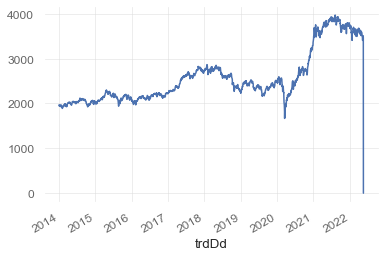

In [37]:
kospi_calculated.plot()

<AxesSubplot:xlabel='Date'>

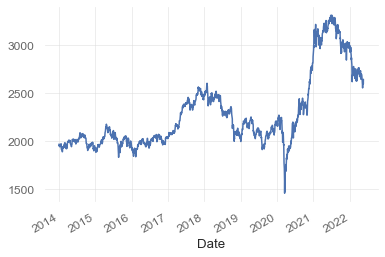

In [38]:
kospi_index_df['Close'].plot()

KOSPI 지수와 직접 계산한 시가총액 기준 지수가 너무 다른 것을 알 수 있다. 

이는 신규종목상장과 상장폐지종목을 고려하지 않았기 때문이다. 

단순 시가총액 합산방식을 쓰는데 중간에 신규종목상장/상장폐지가 발생하면 지수가 불연속적으로 jump 하기 때문에 KRX에서는 이를 고려하여 보정을 하기 때문. 

기준시가총액의 수정이 필요하다. 

산식은 다음과 같다. 

In [ ]:
# row에 대해 count 해주며 상장종목 수가 변한 횟수를 확인. 
# 하지만 count로만 확인할 경우 +1 -1 되면 offset 될 가능성이 있다. 

kospi_marketcap_df.count(axis=1).diff()[:-1].sum() # Probably not accruate

23.0

In [ ]:
existance_arr = np.array(kospi_marketcap_df.isna())

adjustment_days = np.zeros(existance_arr.shape[0])
adjustment_days

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
for idx in range(len(existance_arr[:-1])):
    if not (existance_arr[idx] == existance_arr[idx+1]).all():
        adjustment_days[idx+1] = 1

adjustment_days = adjustment_days.astype(bool)
adjustment_days = kospi_marketcap_df.index[adjustment_days]

아래는 잠시 우리은행꺼. 

In [ ]:
# kospi_ii_l = kospi_univ_df.columns
# kospi_ii2dates = {}

# for ii in kospi_ii_l:
#     dates = kospi_univ_df[ii].index[kospi_univ_df[ii].fillna(False)]
#     if len(dates) > 0:
#         kospi_ii2dates[ii] = dates

In [ ]:
# kosdaq_ii_l = kosdaq_univ_df.columns
# kosdaq_ii2dates = {}

# for ii in kosdaq_ii_l:
#     dates = kosdaq_univ_df[ii].index[kosdaq_univ_df[ii].fillna(False)]
#     if len(dates) > 0:
#         kosdaq_ii2dates[ii] = dates

In [ ]:
# pickle.dump(kospi_ii2dates, open('kospi_ii2dates.pickle','wb'))
# pickle.dump(kosdaq_ii2dates, open('kosdaq_ii2dates.pickle', 'wb'))

In [ ]:
sns.

## 4. Make Finviz-style stock tree map

## 5. Make return correlation clustering DM 

- Also, visualize the result

## 6. Create NLP news DM